# Eurovision's data Exploration

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
import folium

### Loading the data

In [2]:
df_competitions = pd.read_csv('Eurovision full.csv')
df_scores = pd.read_csv('Eurovision score normalized.csv')

## General Data

In [3]:
# How many countries participated each year
contries_by_year = df_competitions.pivot_table(index=['Country'], columns=['Year'], values='Win', aggfunc='count').count()

fig = px.bar(contries_by_year, title='Participants per Year', height=500, labels={'value':'Number of Participants'},
             hover_data={'variable':False}, text='value' ,template='plotly_dark')
fig.add_annotation(x=1970, y=19, text='Due to dissatisfaction from the voting in the 1969', showarrow=True, arrowhead=1)
fig.add_annotation(x=2020, y=20, text='Due to the Covid-19 pandemic', showarrow=True, arrowhead=1, xanchor='right')
fig.update_layout(showlegend=False)
fig.show()

In [4]:
# Participation by countries
winning_countries = df_competitions.groupby(by=['Country']).agg(Won=('Win',sum), Total=('Win','count')).assign(Lose=lambda x: x.Total - x.Won)

fig = px.bar(winning_countries, y=['Lose', 'Won'], title='Participants and Winnings',
             labels={'value':'Number of times', 'variable':'Legend'}, color_discrete_sequence=['green','lightgreen'],
             hover_name=winning_countries.index, hover_data={}, template='plotly_dark', height=500)
fig.show()

In [5]:
geolocator = Nominatim(user_agent='Mozilla/5.0 (X11; Linux x86_64; rv:12.0) Gecko/20100101 Firefox/12.0')

world_map = folium.Map(location=[50.81698601065518, 34.0318617431625], zoom_start=4)
winners = folium.map.FeatureGroup()

first_place = winning_countries['Won'].max()
second_place = winning_countries[winning_countries['Won']<first_place]['Won'].max()
third_place = winning_countries[winning_countries['Won']<second_place]['Won'].max()
icons = {first_place: 'lightgreen', second_place: 'lightblue', third_place: 'red'}

for country,row in winning_countries[winning_countries['Won']>0].iterrows():
    loc = geolocator.geocode(country.replace('Yugoslavia','Belgrad'))
    loc = ([loc.latitude, loc.longitude])
    icon_color = icons.get(row['Won'], 'yellow')
    winners.add_child(folium.features.Marker(loc, tooltip=country.replace('Yugoslavia','Former Yugoslavia') + ', ' + str(row['Won']),
                                             icon=folium.Icon(color='gray', icon_color=icon_color, icon='trophy', prefix='fa')))
world_map.add_child(winners)

title = '''
        <h3 align="left" style="font-size:20px"><b>The Winning Countries</b></h3>
        '''
world_map.get_root().html.add_child(folium.Element(title))

world_map

## Correlations between Countries

In [6]:
mutual_scoring_final = df_scores[df_scores['Format']=='Final'].pivot_table(index=['From'], columns=['Country'], values=['N_score'], aggfunc=['mean'], fill_value=0).droplevel([0,1],axis=1)
mutual_scoring_semi = df_scores[df_scores['Format']=='Semi-Final'].pivot_table(index=['From'], columns=['Country'], values=['N_score'], aggfunc=['mean'], fill_value=0).droplevel([0,1],axis=1)

In [7]:
Western_European_and_Others_Group = ['Andorra','Australia','Austria','Belgium','Denmark','Finland','France','Germany','Greece','Iceland','Ireland','Israel','Italy',
                                     'Luxembourg','Malta','Monaco','Netherlands','Norway','Portugal','San Marino','Spain','Sweden','Switzerland','Türkiye','United Kingdom']
Eastern_European_Group = ['Albania','Armenia','Azerbaijan','Belarus','Bosnia & Herzegovina','Bulgaria','Croatia','Czech Republic','Estonia','Georgia','Hungary','Latvia',
                          'Lithuania','Moldova','Montenegro','North Macedonia','Poland','Romania', 'Russia','Serbia','Serbia & Montenegro','Slovakia','Slovenia','Ukraine','Yugoslavia']

### Semi-Finals - According to East and West groups
The UN divides the countries into 5 groups. The ones are relevant in this matter are the: "Western European and Others Group" and "Eastern European Group".

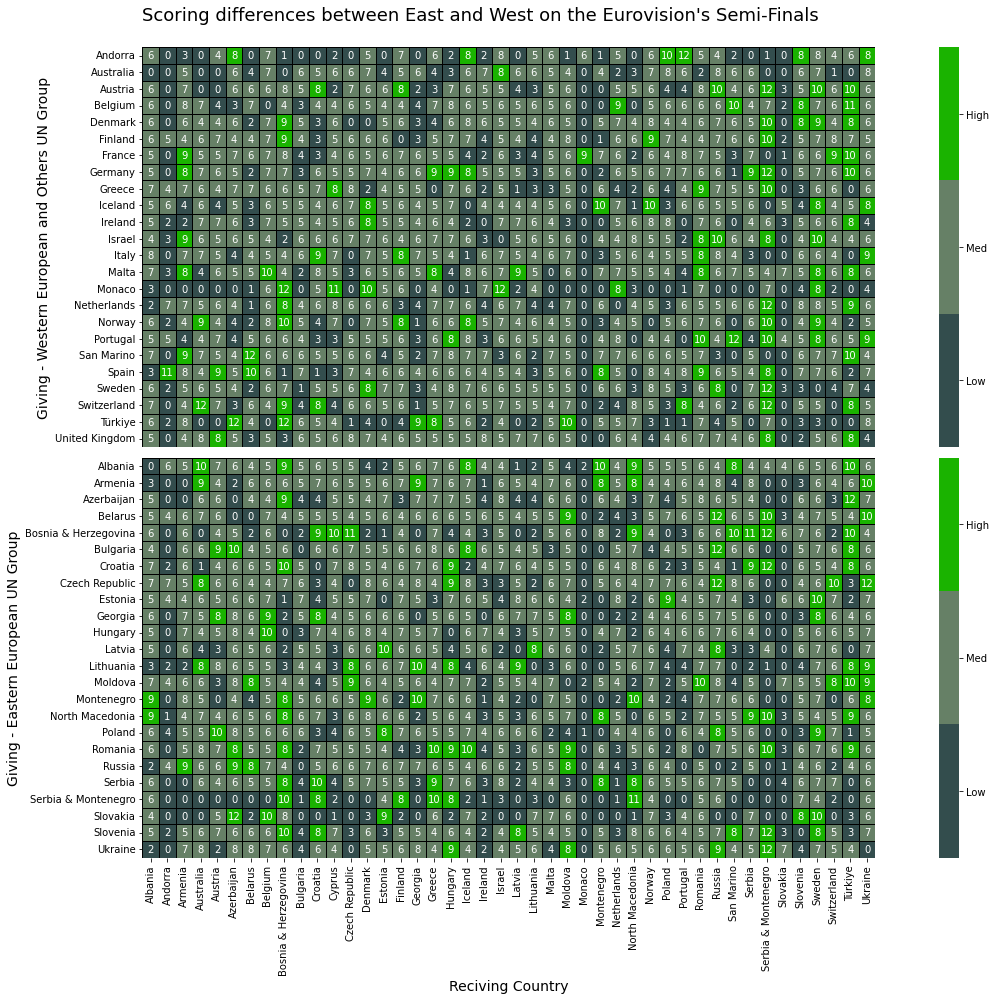

In [8]:
WEaOG_semi = mutual_scoring_semi[mutual_scoring_semi.index.isin(Western_European_and_Others_Group)]
EEG_semi = mutual_scoring_semi[mutual_scoring_semi.index.isin(Eastern_European_Group)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,14))
cmap=[(0.2,0.3,0.3),(0.4,0.5,0.4),(0.1,0.7,0)]

sns.heatmap(WEaOG_semi, cmap=cmap, annot=True, fmt='.0f', linecolor='black', linewidths=1, square=True, xticklabels=False, ax=ax1)
colorbar1 = ax1.collections[0].colorbar
colorbar1.set_ticks([2,6,10],labels=['Low','Med','High'])

sns.heatmap(EEG_semi, cmap=cmap, annot=True, fmt='.0f', linecolor='black', linewidths=1, square=True, ax=ax2)
colorbar2 = ax2.collections[0].colorbar
colorbar2.set_ticks([2,6,10],labels=['Low','Med','High'])

ax1.set_title("Scoring differences between East and West on the Eurovision's Semi-Finals\n", size=18, loc='left')
ax1.set_ylabel('Giving - Western European and Others UN Group', size=14)
ax1.set_xlabel('')
ax2.set_ylabel('Giving - Eastern European UN Group', size=14)
ax2.set_xlabel('Reciving Country', size=14)

plt.tight_layout()
plt.show()

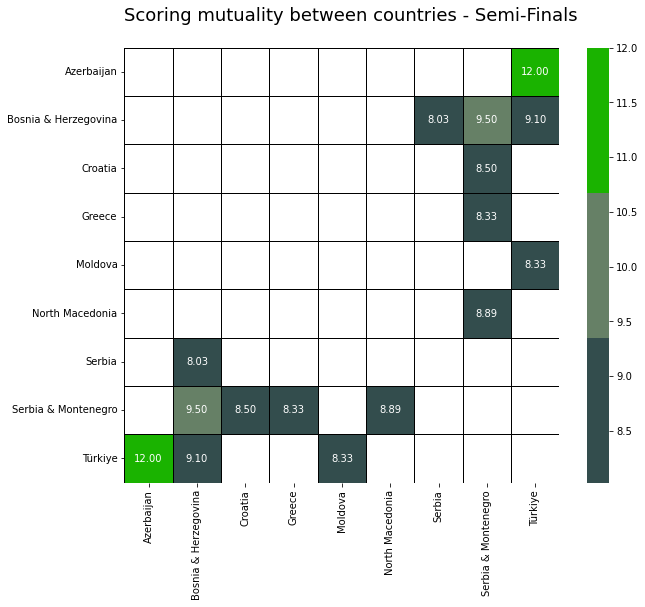

In [9]:
semi_combined = ((mutual_scoring_semi * mutual_scoring_semi.transpose())/12)
semi_combined = semi_combined[semi_combined>=8].dropna(axis=1, how='all').dropna(axis=0, how='all')

plt.figure(figsize=(10,8))
sns.heatmap(semi_combined, cmap=cmap, annot=True, fmt='.2f', linecolor='black', linewidths=1, square=True)
plt.title("Scoring mutuality between countries - Semi-Finals\n", size=18, loc='left')

plt.show()

In [10]:
fixed_scores_semi = mutual_scoring_semi[mutual_scoring_semi>=8].melt(ignore_index=False, value_name='Mean_score').dropna().sort_index().reset_index()
fixed_scores_semi['Format']='Semi-Final'

fixed_scores_semi.loc[fixed_scores_semi['From'].isin(Western_European_and_Others_Group),['Giving Group']] = 'Western European and Others'
fixed_scores_semi.loc[fixed_scores_semi['From'].isin(Eastern_European_Group),['Giving Group']] = 'Eastern European'
fixed_scores_semi['Giving Group'].fillna('None', inplace=True)

fixed_scores_semi.loc[fixed_scores_semi['Country'].isin(Western_European_and_Others_Group),['Reciving Group']] = 'Western European and Others'
fixed_scores_semi.loc[fixed_scores_semi['Country'].isin(Eastern_European_Group),['Reciving Group']] = 'Eastern European'
fixed_scores_semi['Reciving Group'].fillna('None', inplace=True)

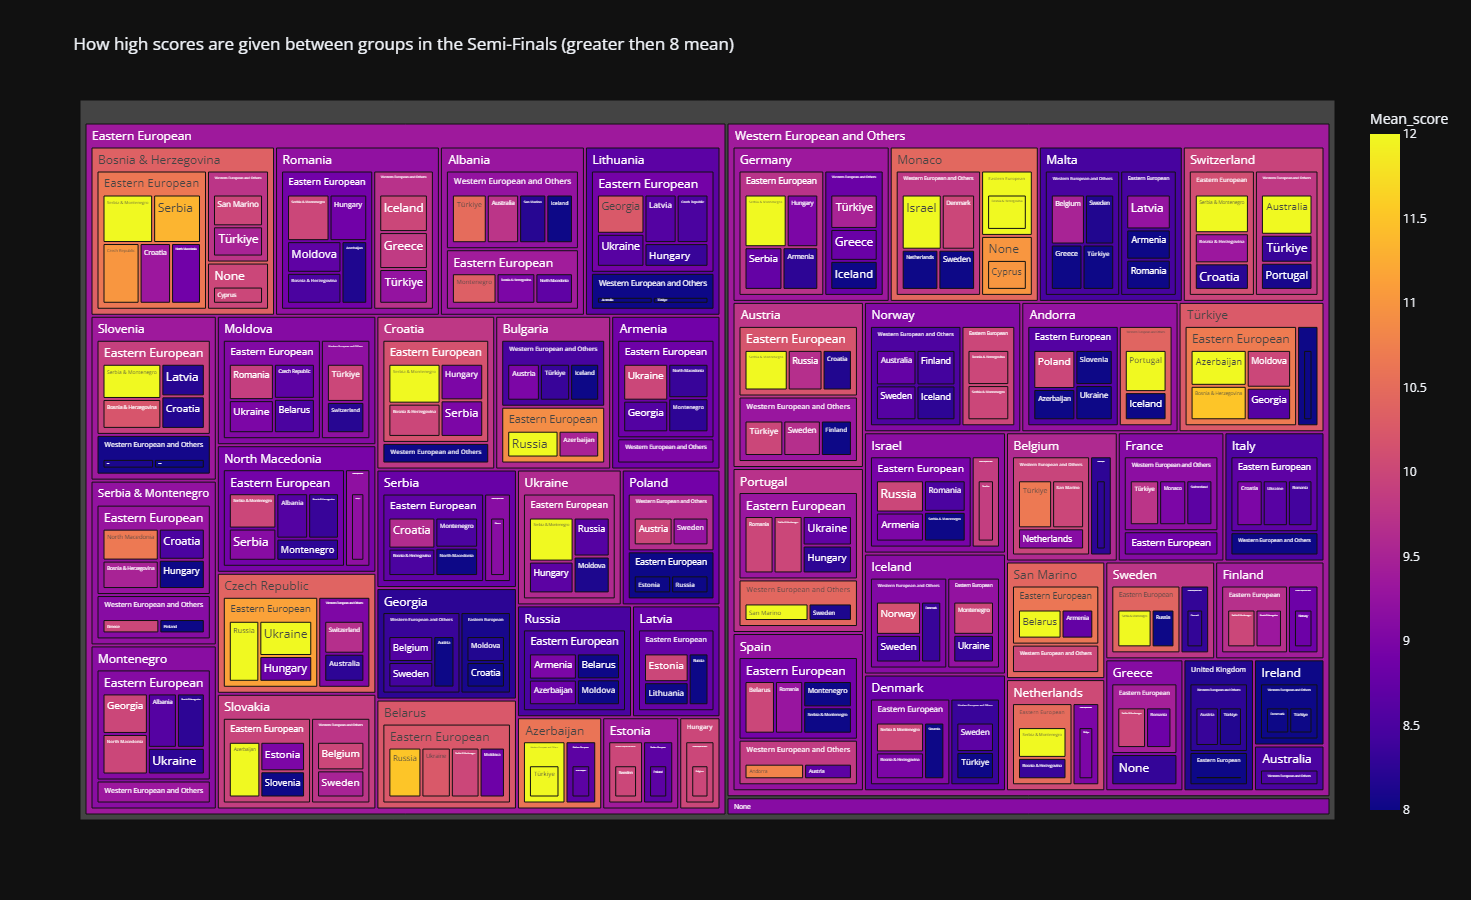

In [11]:
fig = px.treemap(fixed_scores_semi, path=['Giving Group','From','Reciving Group','Country'], values='Mean_score', color='Mean_score',
                 title='How high scores are given between groups in the Semi-Finals (greater then 8 mean)',
                 height=900, template='plotly_dark')
fig.show()

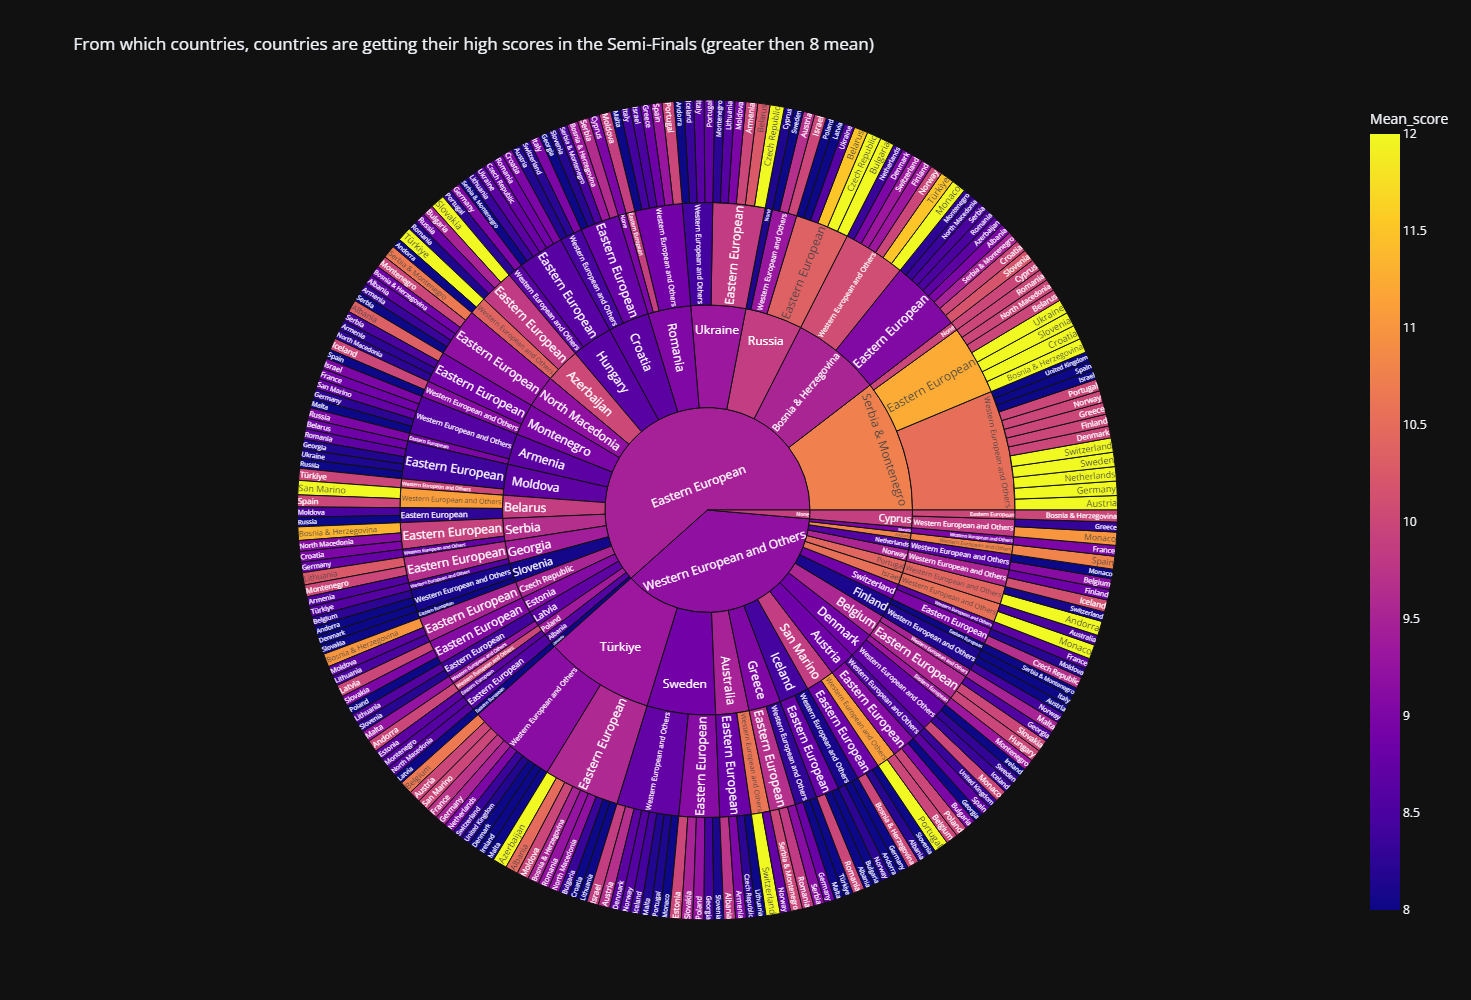

In [12]:
fig = px.sunburst(fixed_scores_semi, path=['Reciving Group','Country','Giving Group','From'], values='Mean_score', color='Mean_score', 
                  title='From which countries, countries are getting their high scores in the Semi-Finals (greater then 8 mean)',
                  hover_data={'Mean_score':False}, labels={'id':'path'}, height=1000, template='plotly_dark')
fig.show()

### Finals - According to East and West groups
The UN divides the countries into 5 groups. The ones are relevant in this matter are the: "Western European and Others Group" and "Eastern European Group".

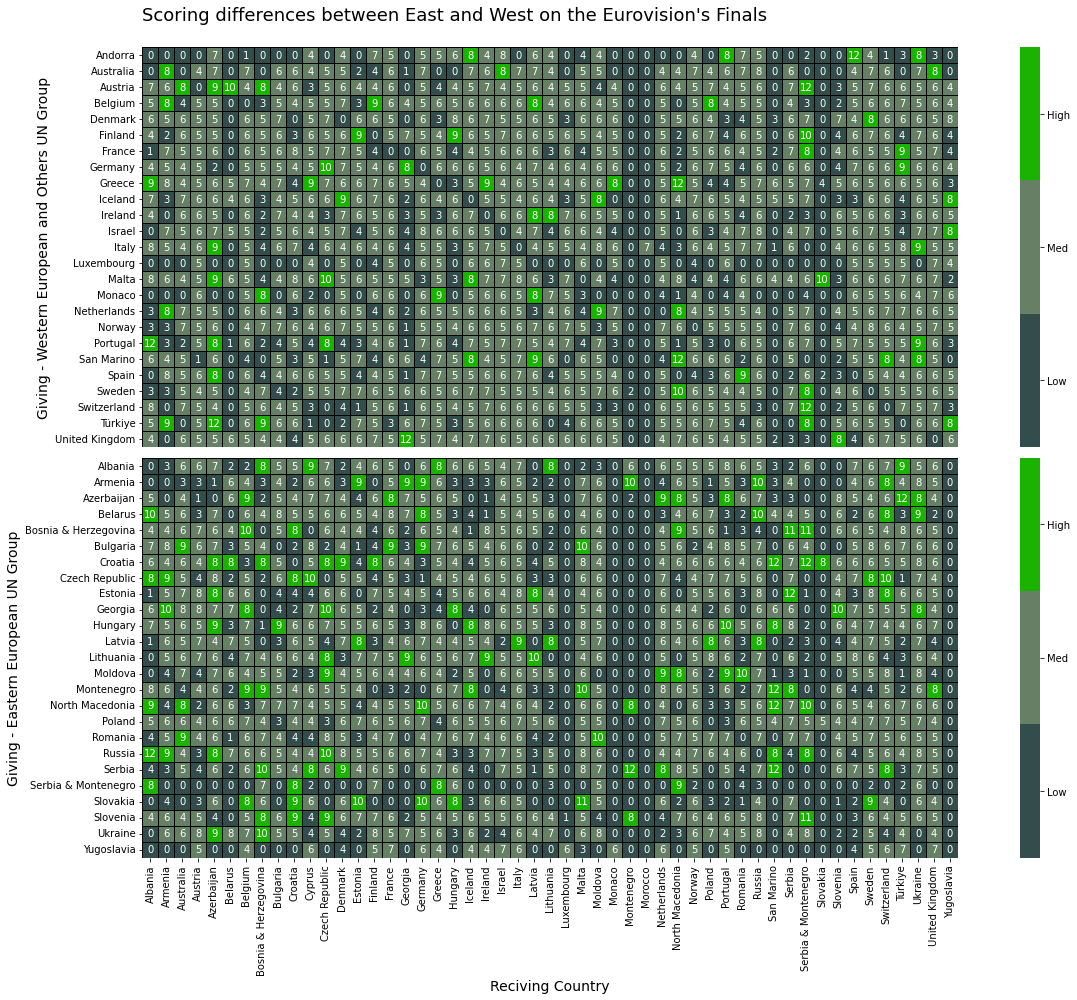

In [13]:
WEaOG = mutual_scoring_final[mutual_scoring_final.index.isin(Western_European_and_Others_Group)]
EEG = mutual_scoring_final[mutual_scoring_final.index.isin(Eastern_European_Group)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,14))
cmap=[(0.2,0.3,0.3),(0.4,0.5,0.4),(0.1,0.7,0)]

sns.heatmap(WEaOG, cmap=cmap, annot=True, fmt='.0f', linecolor='black', linewidths=1, square=True, xticklabels=False, ax=ax1)
colorbar1 = ax1.collections[0].colorbar
colorbar1.set_ticks([2,6,10],labels=['Low','Med','High'])

sns.heatmap(EEG, cmap=cmap, annot=True, fmt='.0f', linecolor='black', linewidths=1, square=True, ax=ax2)
colorbar2 = ax2.collections[0].colorbar
colorbar2.set_ticks([2,6,10],labels=['Low','Med','High'])

ax1.set_title("Scoring differences between East and West on the Eurovision's Finals\n", size=18, loc='left')
ax1.set_ylabel('Giving - Western European and Others UN Group', size=14)
ax1.set_xlabel('')
ax2.set_ylabel('Giving - Eastern European UN Group', size=14)
ax2.set_xlabel('Reciving Country', size=14)

plt.tight_layout()
plt.show()

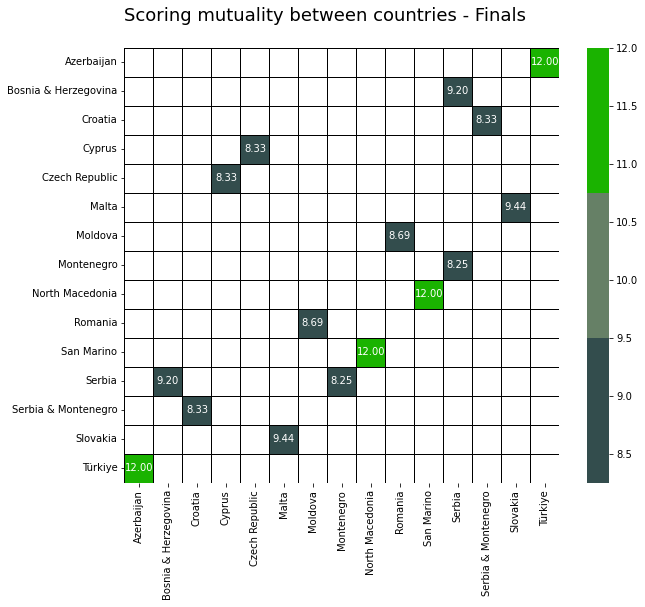

In [14]:
final_combined = ((mutual_scoring_final * mutual_scoring_final.transpose())/12)
final_combined = final_combined[final_combined>=8].dropna(axis=1, how='all').dropna(axis=0, how='all')

plt.figure(figsize=(10,8))
sns.heatmap(final_combined, cmap=cmap, annot=True, fmt='.2f', linecolor='black', linewidths=1, square=True)
plt.title("Scoring mutuality between countries - Finals\n", size=18, loc='left')

plt.show()

In [15]:
fixed_scores_final = mutual_scoring_final[mutual_scoring_final>=8].melt(ignore_index=False, value_name='Mean_score').dropna().sort_index().reset_index()
fixed_scores_final['Format']='Final'

fixed_scores_final.loc[fixed_scores_final['From'].isin(Western_European_and_Others_Group),['Giving Group']] = 'Western European and Others'
fixed_scores_final.loc[fixed_scores_final['From'].isin(Eastern_European_Group),['Giving Group']] = 'Eastern European'
fixed_scores_final['Giving Group'].fillna('None', inplace=True)

fixed_scores_final.loc[fixed_scores_final['Country'].isin(Western_European_and_Others_Group),['Reciving Group']] = 'Western European and Others'
fixed_scores_final.loc[fixed_scores_final['Country'].isin(Eastern_European_Group),['Reciving Group']] = 'Eastern European'
fixed_scores_final['Reciving Group'].fillna('None', inplace=True)

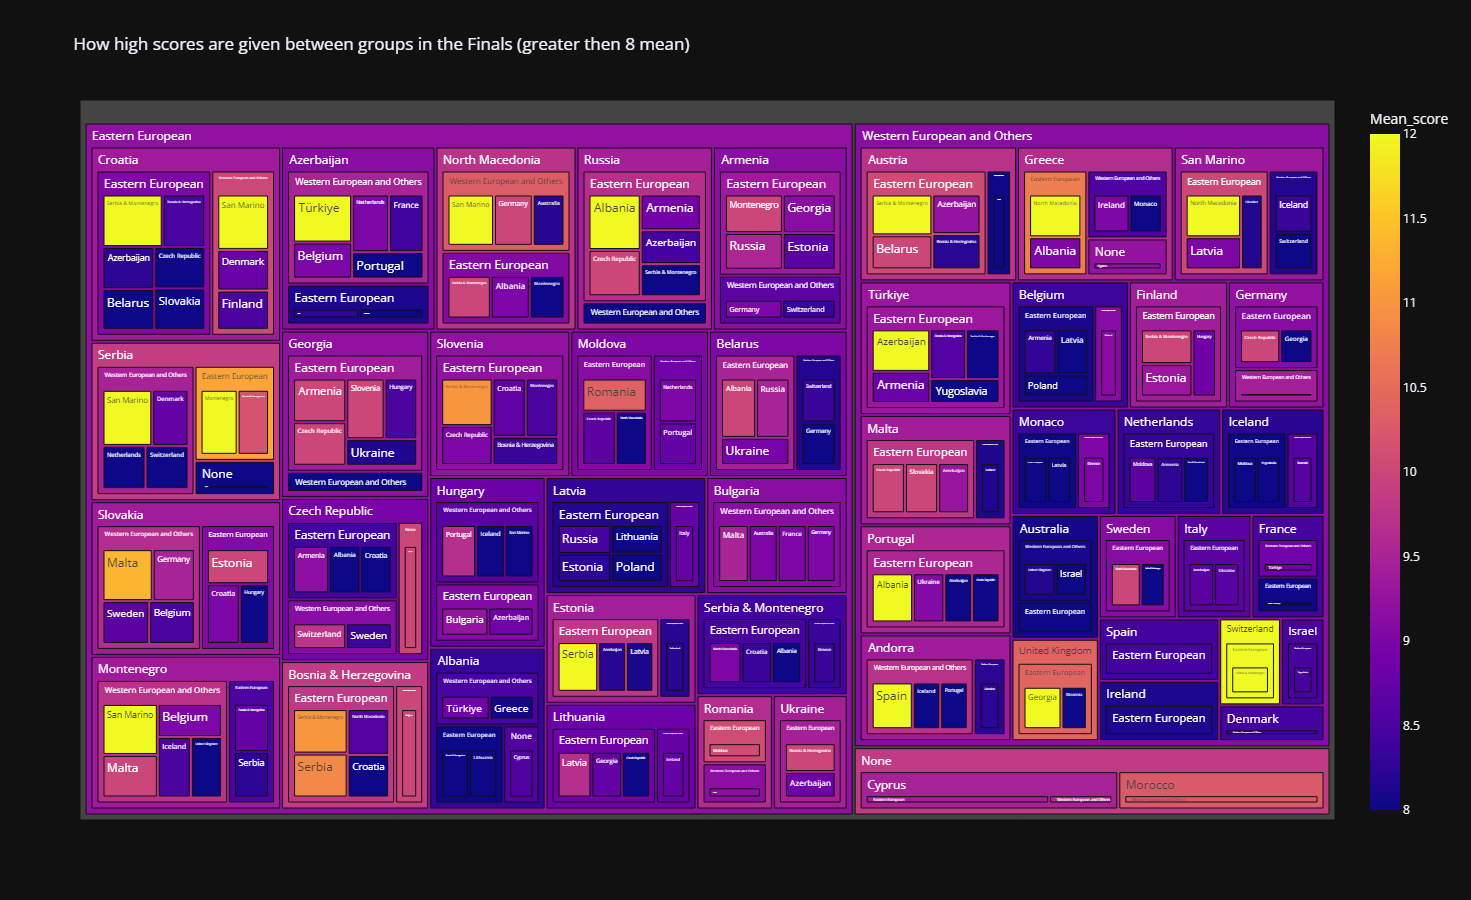

In [16]:
fig = px.treemap(fixed_scores_final, path=['Giving Group','From','Reciving Group','Country'], values='Mean_score', color='Mean_score',
                 title='How high scores are given between groups in the Finals (greater then 8 mean)', height=900, template='plotly_dark')
fig.show()

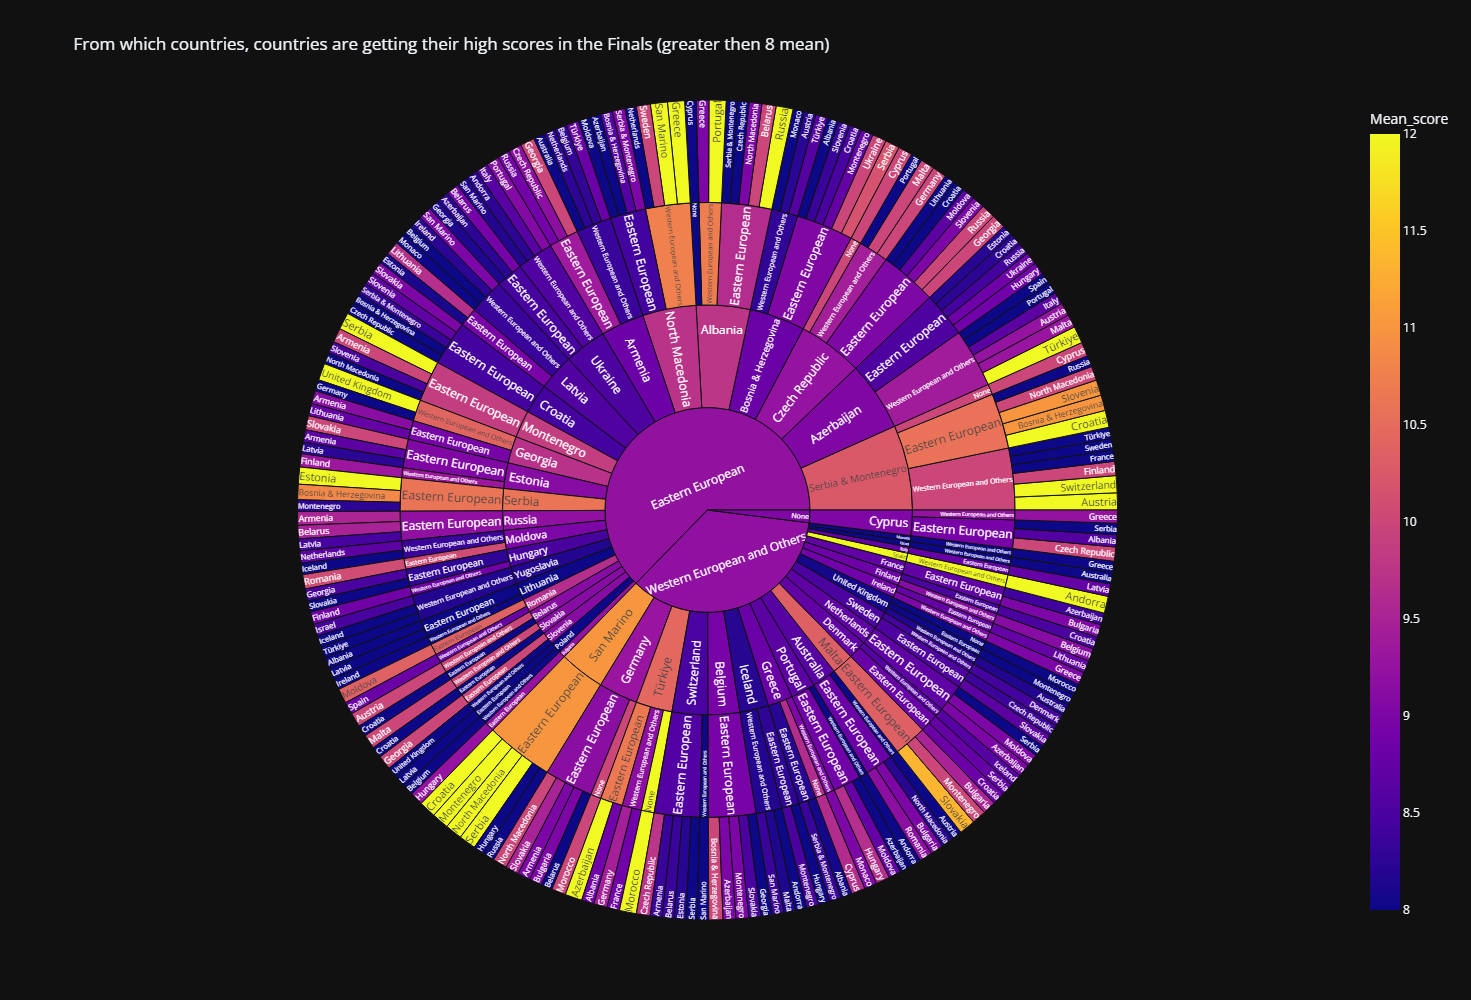

In [17]:
fig = px.sunburst(fixed_scores_final, path=['Reciving Group','Country','Giving Group','From'], values='Mean_score', color='Mean_score', 
                  title='From which countries, countries are getting their high scores in the Finals (greater then 8 mean)',
                  hover_data={'Mean_score':False}, labels={'id':'path'}, height=1000, template='plotly_dark')
fig.show()

### Mutual scoring between groups

In [18]:
fixed_scores_total = pd.concat([fixed_scores_semi,fixed_scores_final])

fixed_scores_total = fixed_scores_total.pivot_table(index=['Format','Giving Group','Reciving Group'], values=['Mean_score'], aggfunc=['count','mean'], fill_value=0).droplevel([0],axis=1).reset_index()
fixed_scores_total.columns = ['Format','Giving scores','Reciving scores','Votes','Mean_score']

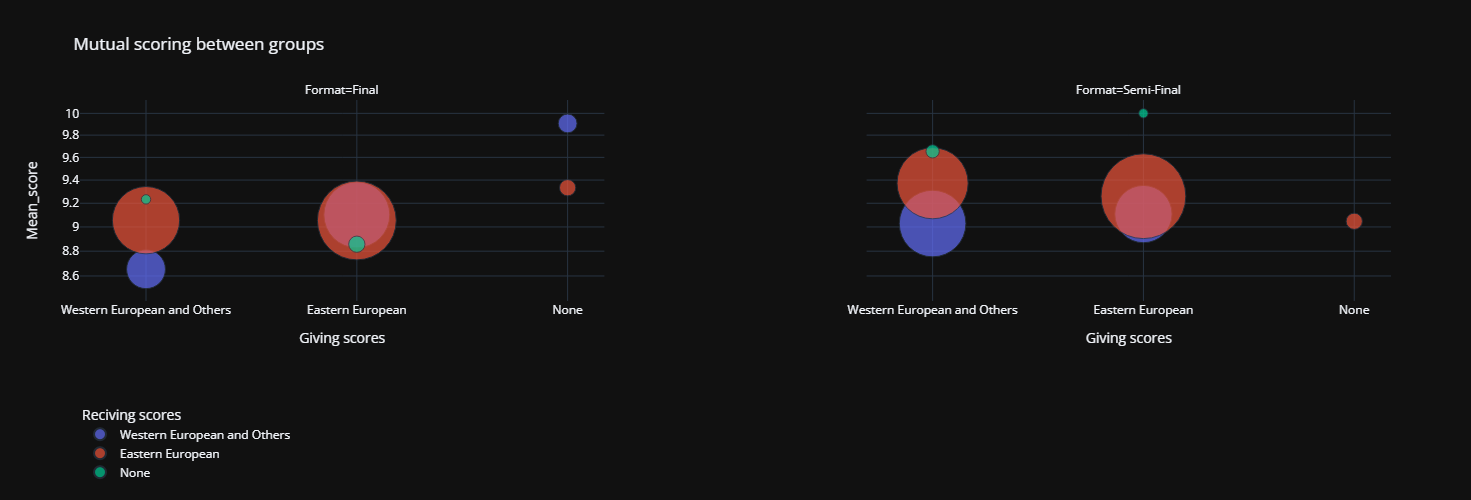

In [19]:
fig = px.scatter(fixed_scores_total, x='Giving scores', y='Mean_score', color='Reciving scores', size='Votes', facet_col='Format', facet_col_spacing=0.2,
                 category_orders={'Giving scores':['Western European and Others','Eastern European','None'],
                                 'Reciving scores':['Western European and Others','Eastern European','None']},
                 title='Mutual scoring between groups', height=500, log_y=True, size_max=60,
                 hover_name='Reciving scores', template='plotly_dark')
fig.update_layout(legend=dict(yanchor="top", xanchor="left", y=-0.5, x=0))
fig.show()

## Scoring reliability between Semi-Finals and Finals

In [20]:
semi_vs_final = df_scores[df_scores['Year']>=2004].copy()

semi_vs_final = semi_vs_final.pivot_table(index=['Year','From','Country','Score_type'], columns=['Format'], values=['N_score'], aggfunc=['mean']).droplevel([0,1], axis=1).reset_index()
semi_vs_final['Gap'] = abs(semi_vs_final['Final']-semi_vs_final['Semi-Final'])
semi_vs_final = semi_vs_final.pivot_table(index=['From'], columns=['Score_type'], values='Gap', aggfunc='mean')
semi_vs_final = semi_vs_final.melt(ignore_index=False, value_name='Gap').dropna().sort_index().reset_index()

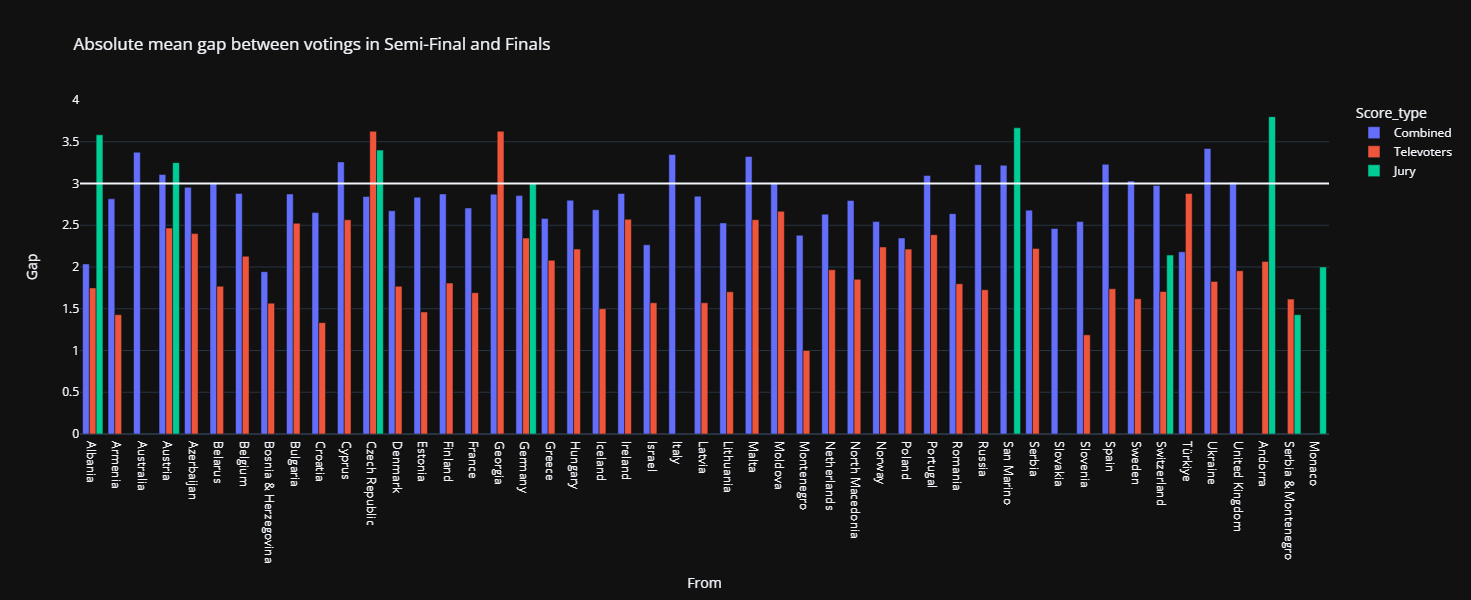

In [21]:
fig = px.bar(semi_vs_final.sort_values('From'), x='From', y='Gap', color='Score_type',height=600, template='plotly_dark', barmode='group',
            title='Absolute mean gap between votings in Semi-Final and Finals')
fig.add_hline(3)                  
fig.show()

# Conclusions

1. The amount of participation countries since 2005 is relatively stable around 40 (give or take 3).
2. High and current mutual scoring relationships on **Semi-Finals** (in average):

| Countries                      | Mean Score       |
| ------------------------------ |:----------------:|
| ***Azerbaijan – Türkiye***     | 12 points        |
| Bosnia & Herzegovina – Türkiye | 9.1 points       |
| Malta – Slovakia               | 9.44 points      |
| Moldova – Türkiye              | 8.33 points      |
| Bosnia & Herzegovina – Serbia  | 8.03 points      |

3. High and current mutual scoring relationships on **Finals** (in average):

| Countries                      | Mean Score       |
| ------------------------------ |:----------------:|
| ***Azerbaijan – Türkiye***     | 12 points        |
| North Macedonia – San Marino   | 12 points        |
| Malta – Slovakia               | 9.44 points      |
| Bosnia & Herzegovina – Serbia  | 9.2 points       |
| Moldova – Romania              | 8.69 points      |
| Cyprus – Czech Republic        | 8.33 points      |
| Montenegro – Serbia            | 8.25 points      |

4. **Most of the scorings in the East European group will be given inside the group**. 
5. In **the Western European and others group** things look a bit different as they **tend to score in more equal way between the groups with a tend to the East**.
6. When it comes to the Finals, **the Western European and others group’s countries tend to give their high scores in more diverse way**. 
7. As for the gap between the scores in the Semi-Finals and the Finals, **most of the combined scores (Jury & Televoters) varies in 3 points give or take**. So, when a country gives a very high score to another country on the Semi-Final it will probably remain high on the Finals.
